## Load data from file

In [1]:
%matplotlib notebook

import numpy as np
with np.load('dimredux-challenge-01-data.npz') as fh:
    data_x = fh['data_x']
    validation_x = fh['validation_x']
    validation_y = fh['validation_y']
# TRAINING DATA:
print(data_x.shape, data_x.dtype)
# VALIDATION DATA:
print(validation_x.shape, validation_x.dtype)
print(validation_y.shape, validation_y.dtype)
# TRAIN MODEL ON data_x
# VALIDATE ON validation_x and validation_y
# PREDICT prediction FROM data_x

(100000, 3) float64
(1000, 3) float64
(1000,) int32


## Plot data in three dimensions

In [3]:
import matplotlib.pyplot as plt
import matplotlib.animation as animation

<IPython.core.display.Javascript object>


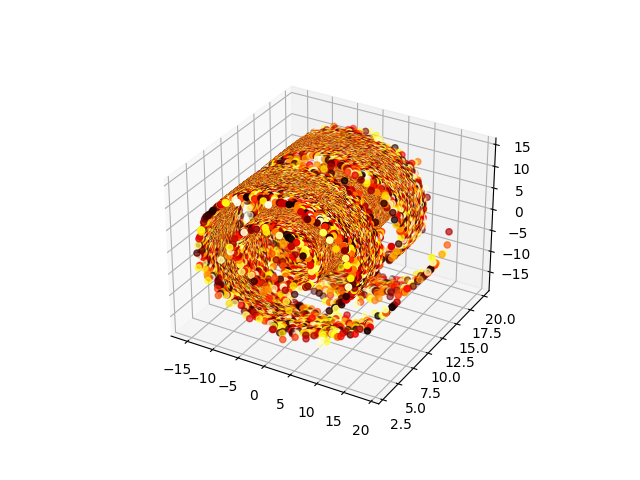

In [3]:
# plot all points (over time) in one plot
def plot_data_time(data):
    fig = plt.figure()
    ax = plt.axes(projection='3d')
    time = np.arange(data[:,0].size)
    ax.scatter3D(data[:,0],data[:,1],data[:,2],c=time,cmap=plt.hot())

plot_data_time(data_x)

## Plot density of data

<IPython.core.display.Javascript object>


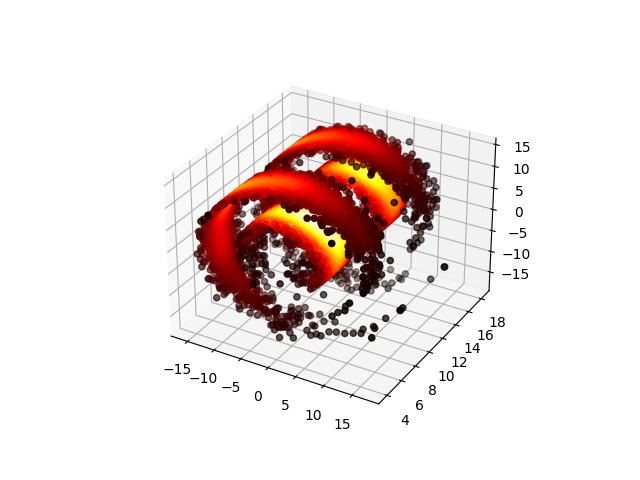

In [4]:
# plot the first 100 points (over time) in one plot and color according to density

from scipy.stats import gaussian_kde

def plot_data_density(data):
    fig = plt.figure()
    ax = plt.axes(projection='3d')
    xyz = np.vstack([data[:,0],data[:,1],data[:,2]])
    density = gaussian_kde(xyz)(xyz)
    
    ax.scatter3D(data[:,0],data[:,1],data[:,2],c=density,cmap=plt.hot())

plot_data_density(data_x[:10000])

## Plot validation data

<IPython.core.display.Javascript object>


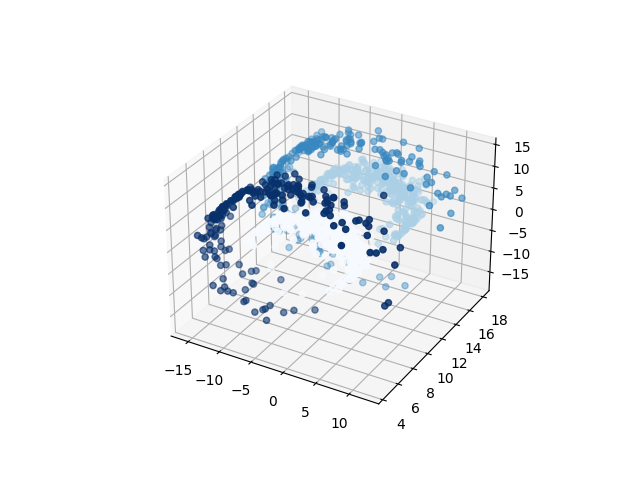

In [5]:
fig = plt.figure()
ax = plt.axes(projection='3d')
ax.scatter3D(validation_x[:,0],validation_x[:,1],validation_x[:,2],c=validation_y,cmap='Blues')

## Plot data over time

<IPython.core.display.Javascript object>


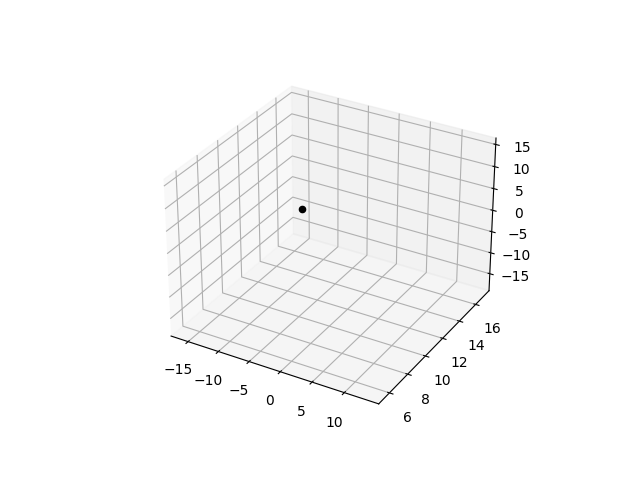

In [46]:
# the point is often behind the density plot and can not be seen. This can not be fixed (there is an matplotlib issue for that)

fig = plt.figure()
ax = plt.axes(projection='3d')
points_in_time=[]
m_points=100
n_density=1000

for data_point in data_x[:m_points]:
    points_in_time.append([ax.scatter3D(data_point[0],data_point[1],data_point[2],c='Black',zorder=2)])

ani = animation.ArtistAnimation(fig, points_in_time, interval=200, blit=True,repeat=False)

plt.show()

# Prepare data

## Split to X and Y

In [5]:
tau = 25
T = len(data_x)
train_x_raw = data_x[:T-tau]
train_y_raw = data_x[tau:]

## Remove mean values

In [6]:
def zero_mean(data):
    mean = data.mean(axis=0)
    zero_mean_data=data-mean[np.newaxis,:]
    return zero_mean_data,mean

train_x,x_mean = zero_mean(train_x_raw)
train_y,y_mean = zero_mean(train_y_raw)

<IPython.core.display.Javascript object>


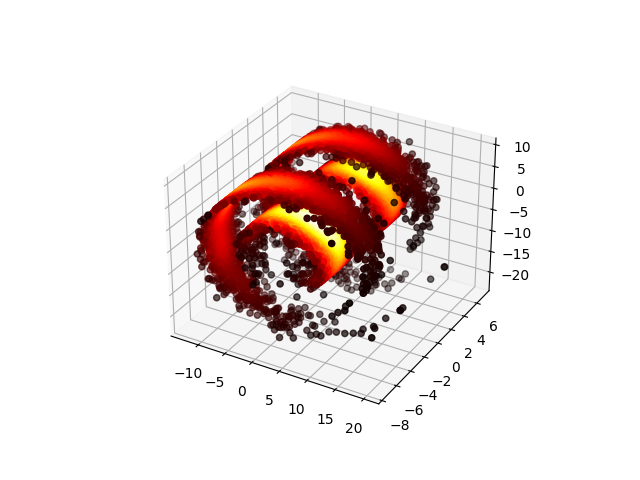

In [9]:
plot_data_density(train_x[:10000])

## Rotate and whiten the data

In [7]:
import numpy.linalg as linalg

def whiten(data):
    # compute covariance matrix (normalized by len(train_x)=T-tau)
    cov = np.cov(data, rowvar=False, bias=True) # same result as np.dot(train_x.transpose(),train_x)/len(train_x)

    # Eigenvalue decomposition
    eigenvalues, eigenvectors= linalg.eig(cov)

    # Decorrelate data by transposing using eigenvectors (this is PCA)
    data_rotated = np.dot(data,eigenvectors)
    
    # Whiten (by dividing by eigenvalues)
    data_whitened = np.dot(data_rotated,np.diag(1/(eigenvalues**0.5)))

    return data_whitened, data_rotated, cov, eigenvalues, eigenvectors

train_x_whitened, x_rotated, cov_xx, x_eigenvalues, x_eigenvectors = whiten(train_x)
train_y_whitened, y_rotated, cov_yy, y_eigenvalues, y_eigenvectors = whiten(train_y)

## Plot rotated data 

<IPython.core.display.Javascript object>


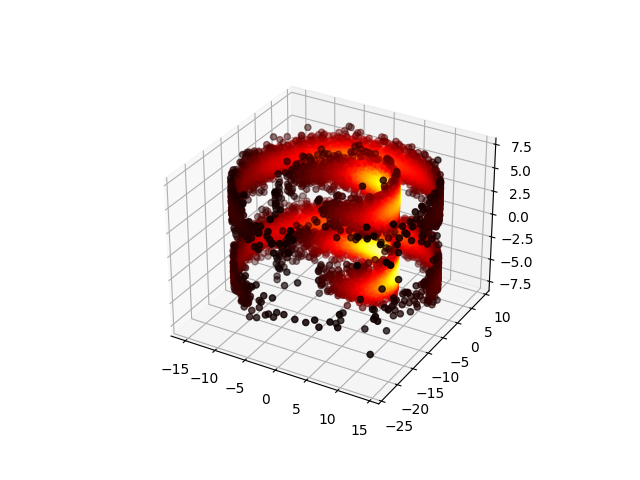

In [11]:
plot_data_density(x_rotated[:10000])

## Plot whitened data

<IPython.core.display.Javascript object>


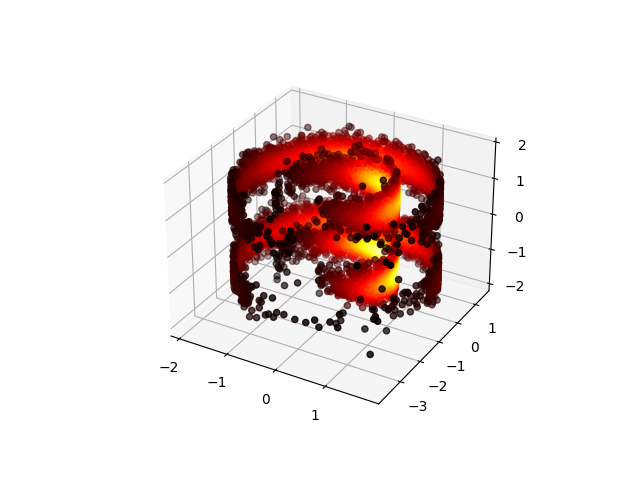

In [25]:
plot_data_density(train_x_whitened[:10000])

## Reconstruct data from whitened data

<IPython.core.display.Javascript object>


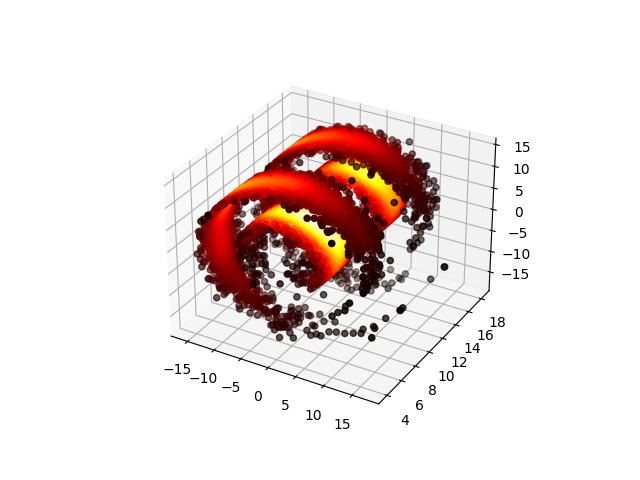

In [13]:
train_x_rotated_rec = np.dot(train_x_whitened, np.diag(x_eigenvalues**0.5))
train_x_rec = np.dot(train_x_rotated_rec, linalg.inv(x_eigenvectors))
train_x_raw_rec = train_x_rec+x_mean
plot_data_density(train_x_raw_rec[:10000])

## Choose tau

<IPython.core.display.Javascript object>


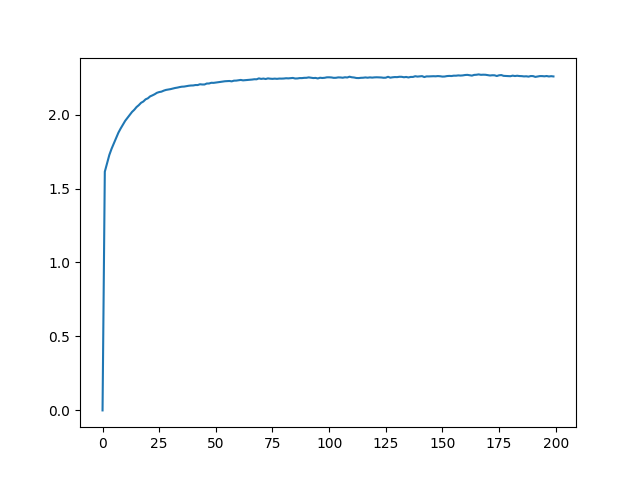

In [42]:
def get_tau_difference(x,tau):
    T = len(x)
    x_test = x[:T-tau]
    y_test = x[tau:]
    distance=np.linalg.norm(x_test - y_test,axis=1)
    return distance.mean()

distances=[]
tau_values=np.arange(200)

for tau in tau_values:
    distance=get_tau_difference(train_x_whitened,tau)
    distances.append(distance)
    
fig=plt.figure()
plt.plot(tau_values,distances)

Looks like tau = 25 could be good

# Define and train the model

## Define the model

In [8]:
from torch import nn

class Autoencoder(nn.Module):
    
    def __init__(self):
        super().__init__()
        
        self.encoder = nn.Sequential(
            nn.Linear(in_features=3, out_features=50),
            nn.Tanh(),
            nn.Linear(in_features=50, out_features=50),
            nn.Tanh(),
            nn.Linear(in_features=50, out_features=4),
            nn.Tanh(),
            nn.Linear(in_features=4, out_features=1),
            nn.Tanh())
        
        self.decoder = nn.Sequential(
            nn.Linear(in_features=1,out_features=4),
            nn.Tanh(),
            nn.Linear(in_features=4,out_features=50),
            nn.Tanh(),
            nn.Linear(in_features=50,out_features=50),
            nn.Tanh(),
            nn.Linear(in_features=50,out_features=3))

    def forward(self, x):
        code = self.encoder(x)
        reconstructed = self.decoder(code)
        return reconstructed
    
    def encode(self,x):
        code = self.encoder(x)
        return code

autoencoder=Autoencoder()

## Prepare Dataloader for training

In [9]:
import torch
from torch.utils.data import TensorDataset

batch_size=64

x_tensor=torch.Tensor(train_x_whitened)
y_tensor=torch.Tensor(train_y_whitened)
train_data=TensorDataset(x_tensor,y_tensor)
trainloader = torch.utils.data.DataLoader(train_data, batch_size)

## Define Loss function and optimizer

In [10]:
import torch.optim as optim

loss_fn = nn.MSELoss() #Mean squared error because it's an regression problem
optimizer = optim.Adam(autoencoder.parameters(), lr=0.001)

## Train the network

50 epochs give a pretty good result. Just run the training as often as you please. 

In [11]:
overall_epochs=0

In [21]:
epochs = 10
print_per_epoch=3
print_running_loss = int((T-tau)/(print_per_epoch*batch_size))

for epoch in range(epochs):  # loop over the dataset multiple times
    overall_epochs+=1
    running_loss = 0.0
    
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        x, y = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = autoencoder(x)
        loss = loss_fn(outputs, y)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % print_running_loss == print_running_loss-1:    # print 10 times during an epoch
            print('[epoch %d, iterations: %5d] loss: %.3f' %
                  (overall_epochs + 1, i + 1, running_loss / print_running_loss))
            running_loss = 0.0
print('Finished Training')

[epoch 42, iterations:   520] loss: 0.991
[epoch 42, iterations:  1040] loss: 0.980
[epoch 42, iterations:  1560] loss: 0.972
[epoch 43, iterations:   520] loss: 0.991
[epoch 43, iterations:  1040] loss: 0.980
[epoch 43, iterations:  1560] loss: 0.972
[epoch 44, iterations:   520] loss: 0.991
[epoch 44, iterations:  1040] loss: 0.980
[epoch 44, iterations:  1560] loss: 0.972
[epoch 45, iterations:   520] loss: 0.991
[epoch 45, iterations:  1040] loss: 0.980
[epoch 45, iterations:  1560] loss: 0.972
[epoch 46, iterations:   520] loss: 0.991
[epoch 46, iterations:  1040] loss: 0.980
[epoch 46, iterations:  1560] loss: 0.972
[epoch 47, iterations:   520] loss: 0.991
[epoch 47, iterations:  1040] loss: 0.980
[epoch 47, iterations:  1560] loss: 0.972
[epoch 48, iterations:   520] loss: 0.991
[epoch 48, iterations:  1040] loss: 0.980
[epoch 48, iterations:  1560] loss: 0.972
[epoch 49, iterations:   520] loss: 0.991
[epoch 49, iterations:  1040] loss: 0.980
[epoch 49, iterations:  1560] loss

## Plot reconstruced Data

<IPython.core.display.Javascript object>


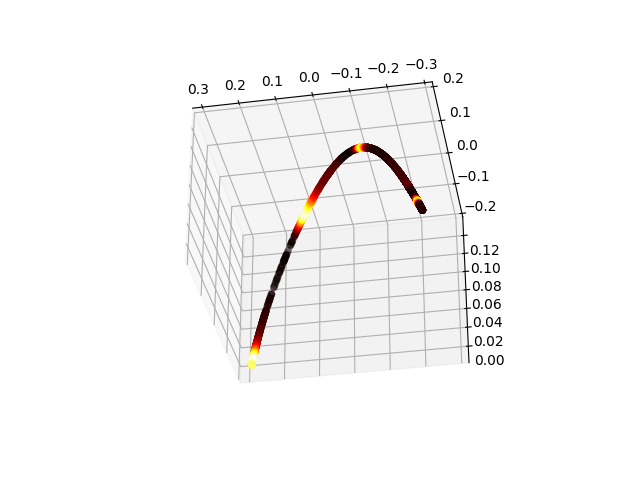

In [22]:
with torch.no_grad():
    reconstructed=autoencoder(x_tensor)
    plot_data_density(reconstructed[:10000])

## Plot the original data with predicted classification

<IPython.core.display.Javascript object>


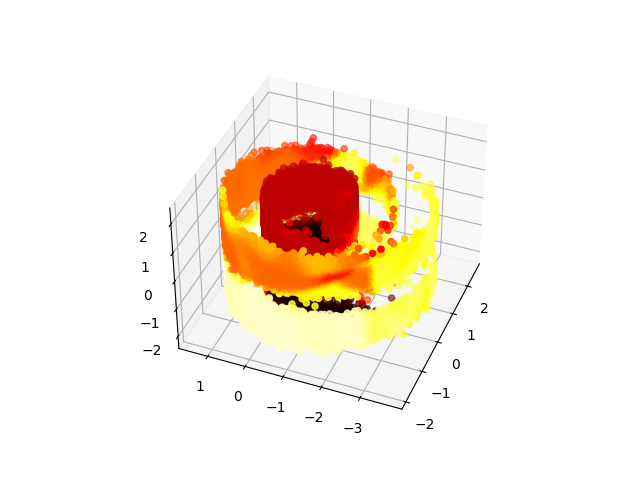

In [23]:
with torch.no_grad():
    codes = autoencoder.encode(x_tensor).numpy()[:,0]
    
fig = plt.figure()
ax = plt.axes(projection='3d')
time = np.arange(train_x_whitened[:,0].size)
ax.scatter3D(train_x_whitened[:,0],train_x_whitened[:,1],train_x_whitened[:,2],c=codes,cmap=plt.hot())

## Histogram of the codes

<IPython.core.display.Javascript object>


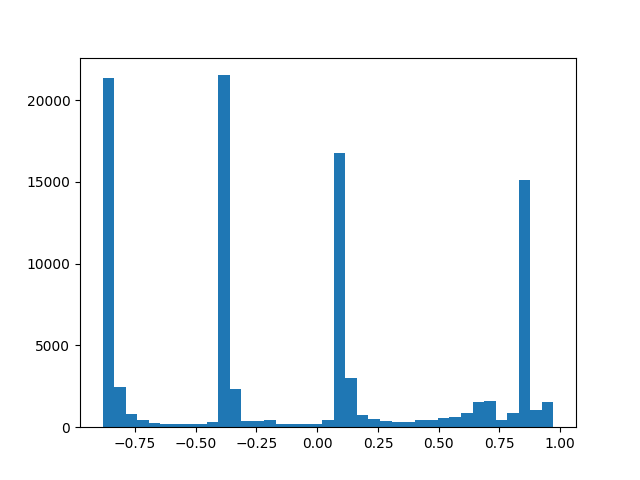

In [24]:
fig = plt.figure()
plt.hist(codes, bins='auto')
plt.show()

## Get labels from 0 to 3 and plot prediction

<IPython.core.display.Javascript object>


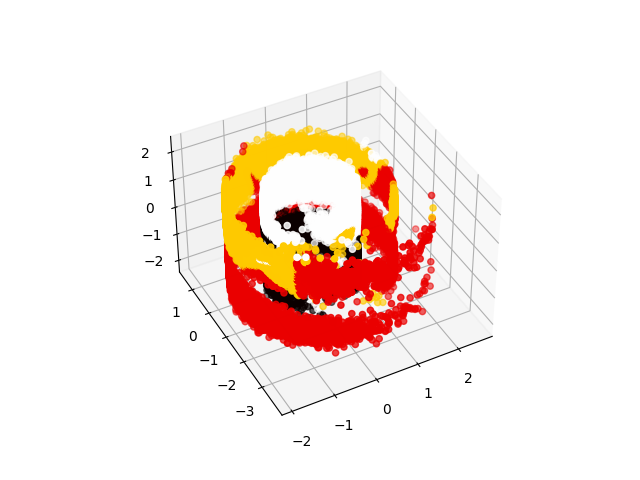

In [47]:
from sklearn.cluster import KMeans
cluster=KMeans(4).fit(codes.reshape(-1, 1))

fig = plt.figure()
ax = plt.axes(projection='3d')
time = np.arange(train_x_whitened[:,0].size)
ax.scatter3D(train_x_whitened[:,0],train_x_whitened[:,1],train_x_whitened[:,2],c=cluster.labels_,cmap=plt.hot())

## Check the prediction format

In [13]:
# MAKE SURE THAT YOU HAVE THE RIGHT FORMAT
assert prediction.ndim == 1
assert prediction.shape[0] == 100000
# AND SAVE EXACTLY AS SHOWN BELOW
np.save('prediction.npy', prediction.astype(int))
# MAKE SURE THAT THE FILE HAS THE CORRECT FORMAT
def validate_prediction_format():
    loaded = np.load('prediction.npy')
    assert loaded.shape == (100000, )
    assert loaded.dtype == int
    assert (loaded <= 3).all()
    assert (loaded >= 0).all()
validate_prediction_format()

NameError: name 'prediction' is not defined